In [1]:
from Rosenbrock_A import Rosenbrock_dist
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import timeit

import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.animation as animation
tfd = tfp.distributions

In [2]:
Bana_dist = Rosenbrock_dist()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


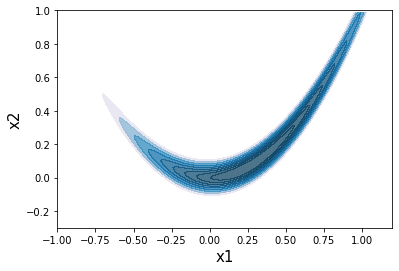

In [3]:
fig,ax = Bana_dist.draw_post()
fig.savefig('probe_levels.png', dpi=300)

In [4]:
def negative_log_posterior(mu):
    return tf.negative(Bana_dist.joint_log_post(mu))[0]

In [5]:
from matplotlib.colors import from_levels_and_colors
Min = tf.constant([[-0.7, 0.5]])
N = 10
U = 50 # upper value
L = 1  # lower value
space = np.logspace(np.log10(U), np.log10(L),N) # create a logspace
space = space/(U-L)*(Bana_dist.joint_log_post(Min)[0]-np.max(Bana_dist.post))
space = space - space[-1] + np.max(Bana_dist.post) # map the logspace to the target range
vmax = np.max(Bana_dist.post)
vmin = Bana_dist.joint_log_post(Min)[0]

midpoint = 1.005*vmax
midp = np.mean(np.c_[space[:-1], space[1:]], axis=1)

vals = np.interp(midp, [vmin, midpoint, vmax], [1, 0.3, 0])

cmap,norm = from_levels_and_colors(space,plt.cm.PuBu(vals))
space

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-201.85837, -182.33302, -169.69078, -161.50519, -156.20518,
       -152.77356, -150.55165, -149.113  , -148.18152, -147.5784 ],
      dtype=float32)>

In [6]:
mu_init = tf.constant([[-0.6,0.4]])
Bana_dist.joint_log_post(mu_init)
fig.savefig('init.png',dpi=300)
print(mu_init)

tf.Tensor([[-0.6  0.4]], shape=(1, 2), dtype=float32)


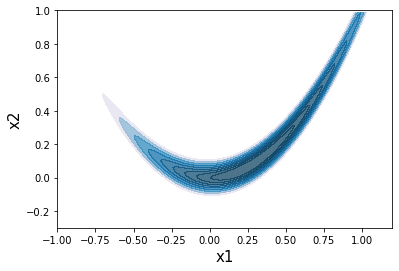

In [7]:
fig

In [8]:
# Function for printing
def loss(mu):
    lost =  negative_log_posterior(mu)
    return lost

# Function for tensorflow optimizer
def loss_minimize():
    lost =  negative_log_posterior(mu)
    return lost

In [9]:
Adam = tf.keras.optimizers.Adam(
    learning_rate=0.03, beta_1=0.9, beta_2=0.999, epsilon=1e-08
)
cost_A = []
mu_list = [mu_init]
mu = tf.Variable(mu_init)
start = timeit.default_timer()

for step in range(300):

    Adam.minimize(loss_minimize, var_list=[mu])
    cost_A.append(loss(mu).numpy())

    mu_list.append(mu.numpy())
end = timeit.default_timer()

In [10]:
mu_list[-1]

array([[0.16487178, 0.02676925]], dtype=float32)

In [11]:
Mu_array = np.array(mu_list)

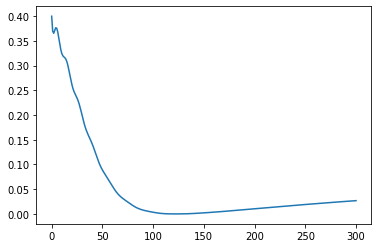

In [12]:
plt.plot(Mu_array[:,0,1])

In [13]:
Mu_array[0,0,1]

0.4

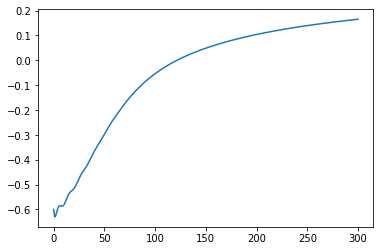

In [14]:
plt.plot(Mu_array[:,0,0])

In [15]:
ax.plot(Mu_array[:,0,0],Mu_array[:,0,1])
ax.scatter(Mu_array[-1,0,0],Mu_array[-1,0,1],c='g')
ax.scatter(Mu_array[0,0,0],Mu_array[0,0,1],c='r')
# fig.savefig('Adam.png',dpi=300)

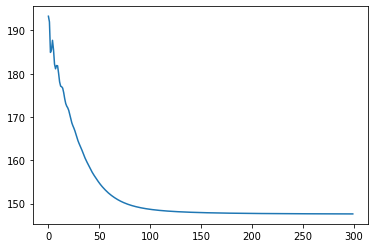

In [16]:
plt.plot(cost_A)

In [17]:
MAP = mu[-1]
MAP = tf.expand_dims(MAP,axis=0)

In [18]:
MAP

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.16487178, 0.02676925]], dtype=float32)>

In [19]:
Bana_dist.joint_log_post(MAP)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-147.62326], dtype=float32)>

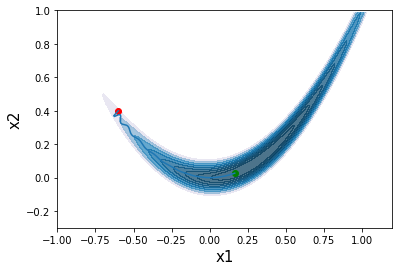

In [20]:
fig

MovieWriter ImageMagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


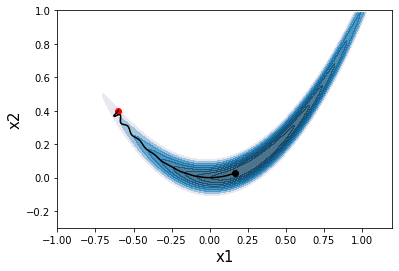

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

x = Mu_array[:,0,0]
y = Mu_array[:,0,1]

fig,ax = Bana_dist.draw_post()
line, = ax.plot(x, y, color='k')

def update(num, x, y, line):
    line.set_data(x[:num], y[:num])
    #line.axes.axis([0, 10, 0, 1])
    if num == (x.shape[0]-1):
         ax.scatter(Mu_array[-1,0,0],Mu_array[-1,0,1],c='k')
    return line,

ax.scatter(Mu_array[0,0,0],Mu_array[0,0,1],c='r')
ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, y, line],
                              interval=25, blit=True, repeat=False)

ani.save('test.gif', dpi = 500,bitrate=500 ,writer='ImageMagick')
plt.show()


In [29]:
x.shape[0]

301

In [20]:
def Hessian(MAP):
  Hess = tf.TensorArray(tf.float32, size=2)
  for i in range(2):

    tangents = np.zeros(MAP.shape)
    tangents[i]=1
    tangents = tf.convert_to_tensor(tangents,dtype=tf.float32)

    with tf.autodiff.ForwardAccumulator(MAP, tangents) as acc:
      with tf.GradientTape(watch_accessed_variables=False) as t:
        t.watch(MAP)
        joint_log =  loss(tf.expand_dims(MAP,axis=0))
      grad = t.gradient(joint_log,MAP)
    hess = acc.jvp(grad)
    Hess = Hess.write(i, hess)
  return(Hess.stack())

In [21]:
start = timeit.default_timer()
Hess = Hessian(MAP)
end = timeit.default_timer()
print('time for gradient calculation: %.3f' % (end - start))

time for gradient calculation: 14.493


In [22]:
Hess

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 103.88071, -259.61768],
       [-259.61768,  793.75385]], dtype=float32)>

In [23]:
def Laplace_appro(Hessian,C_prior):
    cov_post = tf.linalg.inv(
        (tf.add(Hessian, tf.linalg.inv(C_prior))))
    return cov_post

In [24]:
cov_post = Laplace_appro(Hess,tf.constant([[1,  0.], [0.,  1]]))

In [25]:
cov_post

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.04981843, 0.0162739 ],
       [0.0162739 , 0.00657435]], dtype=float32)>

In [26]:
from scipy.stats import multivariate_normal
x = np.linspace(-1, 1, 10, endpoint=False)
y = multivariate_normal.pdf(x, mean=MAP,cov=)

SyntaxError: invalid syntax (<ipython-input-26-f3b8d2cd486a>, line 3)

In [ ]:
mu_init

In [ ]:
tf.expand_dims(MAP,0)

<a href="http://blog.enthought.com/general/visualizing-uncertainty/#.XqC1GdP7RTY"> Plotting reference</a>

In [ ]:
def pdense(x, y, sigma, M=1000):
    """ Plot probability density of y with known stddev sigma
    """
    assert len(x) == len(y) and len(x) == len(sigma)
    N = len(x)
    # TODO: better y ranging
    ymin, ymax = min(y - 2 * sigma), max(y + 2 * sigma)
    yy = np.linspace(ymin, ymax, M)
    a = [np.exp(-((Y - yy) / s) ** 2) / s for Y, s in zip(y, sigma)]
    A = np.array(a)
    A = A.reshape(N, M)
    plt.imshow(-A.T, cmap='gray', aspect='auto',
               origin='lower', extent=(min(x)[0], max(x)[0], ymin, ymax))
    plt.title('Density plot')

In [ ]:
x = np.array([[1],[2],[3]])
y = np.array([[3],[4],[5]])
s2 = np.array([[0.1],[0.2],[0.3]])
pdense(x, y, s2, M=1000)